In [1]:
import sys

sys.path.append("../../src")

import os

# Get the current working directory
current_dir = os.getcwd()

# Move up two directories
grandparent_dir = os.path.abspath(os.path.join(current_dir, "../.."))

import pickle
from utilities import RE_memory
from process_tensor_networks import produce_LPDO
import xyzpy as xyz
import numpy as np
import quimb.tensor as qtn

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pylab as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
from matplotlib import rc
rc('font',**{'family':'Arial','sans-serif':['Helvetica']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 20})

In [4]:
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("deep")

In [5]:
validation_stats_6k3q = pickle.load(
    open(
        os.path.join(
            grandparent_dir,
            "data",
            "IBM_char",
            "device_fit_data",
            "perth_Standard/validation_stats_6k3nQ_512_spc_normal_mode.pickle",
        ),
        "rb",
    )
)

optimiser_stats_6k3q = pickle.load(
    open(
        os.path.join(
            grandparent_dir,
            "data",
            "IBM_char",
            "device_fit_data",
            "perth_Standard/optmzr_6k3nQ_512_spc_normal_mode.pickle",
        ),
        "rb",
    )
)

In [6]:
had = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
X = np.array([[0, 1], [1, 0]])

bell_v = np.array([1, 0, 0, 1], dtype=complex)
had_v = np.kron(had, np.eye(2)) @ bell_v
X_v = np.kron(X, np.eye(2)) @ bell_v

bell_v = np.reshape(bell_v, (2, 2))
had_v = np.reshape(had_v, (2, 2))
X_v = np.reshape(X_v, (2, 2))

In [7]:
def create_labelled_identity_op(time, qubit, choi_v):
    in_label = f"ki{time+1}_q{qubit}"
    out_label = f"ko{time}_q{qubit}"

    bell_k_tn = qtn.Tensor(choi_v, inds=(out_label, in_label), tags=["BELL"])
    bell_b_tn = qtn.Tensor(
        choi_v, inds=("b" + out_label[1:], "b" + in_label[1:]), tags=["BELL"]
    )

    return bell_k_tn & bell_b_tn

In [8]:
def create_identity_sequence(max_time, max_qubit, excluded_t_q):

    had_seq = [
        create_labelled_identity_op(0, Q, had_v)
        for Q in range(max_qubit)
        if (0, Q) not in excluded_t_q
    ]
    bell_seq = [
        create_labelled_identity_op(T, Q, bell_v)
        for T in range(1, max_time)
        for Q in range(max_qubit)
        if (T, Q) not in excluded_t_q
    ]

    return qtn.TensorNetwork(had_seq + bell_seq)

In [9]:
def create_custom_sequence(max_time, max_qubit, excluded_t_q, cust_v):

    bell_seq = [
        create_labelled_identity_op(T, Q, cust_v)
        for T in range(max_time)
        for Q in range(max_qubit)
        if (T, Q) not in excluded_t_q
    ]

    return qtn.TensorNetwork(bell_seq)

In [10]:
def create_partial_trace_sequence(tq_labels):
    PT_seq = []
    for label in tq_labels:
        trace = qtn.Tensor(np.eye(2), inds=("b" + label, "k" + label), tags=["TRACE"])
        PT_seq.append(trace)
    return qtn.TensorNetwork(PT_seq)

In [11]:
ts = 6
nQ = 3

In [12]:
optimal_MPO = optimiser_stats_6k3q[2]
trace_seq = create_partial_trace_sequence(
    [f"o{i}_q{q}" for i in range(ts + 1) for q in range(nQ)]
    + [f"i{i}_q{q}" for i in range(1, ts + 1) for q in range(nQ)]
)
trace_MPO = (trace_seq & produce_LPDO(optimal_MPO)).contract()

optimal_MPO = optimal_MPO / np.sqrt(trace_MPO)

In [13]:
# # test_id_seq = create_identity_sequence(ts,nQ,[(2,0),(2,1),(5,0),(5,1)])
# test_id_seq = create_identity_sequence(ts, nQ, [(2, 0), (2, 1), (3, 0), (3, 1)])
# test_trace_seq = create_partial_trace_sequence(
#     [f"o{ts}_q0", f"o{ts}_q1", f"o{ts}_q2", "i4_q0", "i4_q1", "o2_q0", "o2_q1"]
# )

In [14]:
def get_correlation_pairs(t1, t2, q1, q2, custom_op):
    # custom gate everywhere else on the other qubits if it's just a single...
    # t2 should correspond to q2 and should be greater than t1

    if q1 == q2:
        all_times_and_qubits = [(i, j) for i in range(ts) for j in range(nQ)]
        non_target_qubits = [i for i in range(nQ)]
        non_target_qubits.remove(q1)

        desired_X_gates = [(i, j) for i in range(ts) for j in non_target_qubits]
        for pair in desired_X_gates:
            all_times_and_qubits.remove(pair)

        id_seq = create_identity_sequence(
            ts,
            nQ,
            [(t1, q1), (t2, q1), (t2 + 1, q1)]
            + [(i, j) for i in range(ts) for j in non_target_qubits],
        )
        # X_seq = create_custom_sequence(ts, nQ, all_times_and_qubits, custom_op)
        X_seq = create_identity_sequence(
            ts, nQ, all_times_and_qubits
        )  # THIS INCLUDES THE HADAMARD
        if t2 < ts - 1:
            trace_seq = create_partial_trace_sequence(
                [f"o{ts}_q{q}" for q in range(nQ)] + [f"i{t2+2}_q{q1}"]
            )
        else:
            trace_seq = create_partial_trace_sequence(
                [f"o{ts}_q{q}" for q in non_target_qubits]
            )

        dense_PT = (
            (produce_LPDO(optimal_MPO) & id_seq & trace_seq & X_seq)
            .contract()
            .data.reshape(32, 32)
        )
        dense_PT = dense_PT / np.trace(dense_PT)

    if q1 != q2:
        non_target_qubits = [i for i in range(nQ)]
        non_target_qubits.remove(q2)

        if t1 != t2:
            id_seq = create_identity_sequence(
                ts, nQ, [(t1, q1), (t2, q2), (t2 + 1, q2)]
            )
        if t1 == t2:
            id_seq = create_identity_sequence(
                ts, nQ, [(t1, q1), (t2, q2), (t2 + 1, q2), (t2 + 1, q1)]
            )

        if t2 < ts - 1:
            input_labels = [f"i{t2+2}_q{q2}"]
            if t1 == t2:
                input_labels += [f"i{t1+2}_q{q1}"]
            trace_seq = create_partial_trace_sequence(
                [f"o{ts}_q{q}" for q in range(nQ)] + input_labels
            )
        else:
            if t1 == t2:
                non_target_qubits.remove(q1)
            trace_seq = create_partial_trace_sequence(
                [f"o{ts}_q{q}" for q in non_target_qubits]
            )

        if t1 == t2:
            # return (produce_LPDO(optimal_MPO) & id_seq & trace_seq)
            dense_PT = (
                (produce_LPDO(optimal_MPO) & id_seq & trace_seq)
                .contract()
                .data.reshape(64, 64)
            )
        else:
            dense_PT = (
                (produce_LPDO(optimal_MPO) & id_seq & trace_seq)
                .contract()
                .data.reshape(32, 32)
            )

        dense_PT = dense_PT / np.trace(dense_PT)

    return dense_PT

In [15]:
correlation_matrices = {}
OFFSET = 0.00

for Q_fixed in range(3):
    tmp_cor_mat = np.zeros((3, ts, ts))

    for q_targ in range(3):
        for i in range(ts):
            if q_targ != Q_fixed:
                for j in range(i + 1):
                    if i == j:
                        tmp_cor_mat[q_targ, i, j] = OFFSET + RE_memory(
                            get_correlation_pairs(j, i, q_targ, Q_fixed, bell_v), [8, 8]
                        )
                    else:
                        tmp_cor_mat[q_targ, i, j] = OFFSET + RE_memory(
                            get_correlation_pairs(j, i, q_targ, Q_fixed, bell_v),
                            [4, 4, 2],
                        )
            else:
                for j in range(i):
                    tmp_cor_mat[q_targ, i, j] = OFFSET + RE_memory(
                        get_correlation_pairs(j, i, q_targ, Q_fixed, bell_v), [4, 4, 2]
                    )
    correlation_matrices[Q_fixed] = tmp_cor_mat

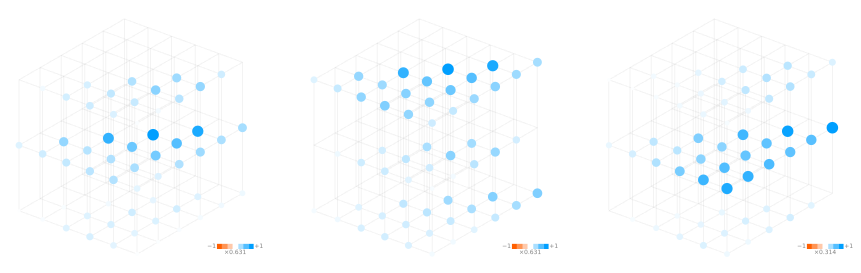

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
for i in range(3):
    xyz.visualize_tensor(
        correlation_matrices[i],
        legend=True,
        ax=axs[i],
        rasterize=None,
        rasterize_dpi=None,
        alpha_map=False,
        alpha=1,
    )
# plt.savefig("test_2.svg", bbox_inches="tight")